In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from z3 import *
import time

In [2]:
circ = QuantumCircuit().from_qasm_file('test.qasm')

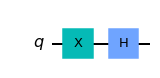

In [3]:
circ.draw('mpl')

In [4]:
def is_diagonal(U):
    i, j = np.nonzero(U)
    return np.all(i == j)

def add_hyper_index(var_list,hyper_index):
    for var in var_list:
        if not var in hyper_index:
            hyper_index[var]=0
            
def reshape(U):
    if U.shape==(2,2):
        return U
    
    if U.shape[0]==U.shape[1]:
        split_U=np.split(U,2,1)
    else:
        split_U=np.split(U,2,0)
    split_U[0]=reshape(split_U[0])
    split_U[1]=reshape(split_U[1]) 
    return np.array([split_U])[0]            
            
def get_real_qubit_num(cir):
    """Calculate the real number of qubits of a circuit"""
    gates=cir.data
    q=0
    for k in range(len(gates)):
        q=max(q,max([qbit.index for qbit in gates[k][1]]))
    return q+1

In [5]:
class Term:
    def __init__(self, attr=0.+0.j, ref=None):
        self.attr = attr
        self.ref = ref
    def tensor(self, t1=None):
        attr1 = self.attr * t1.attr
        ref1 = And(self.ref, t1.ref)
        return Term(attr1, ref1)
    def exist(self, ex_list=[]):
        pass
    def sequential(self, t1=None, ex_list=[]): # ex_list: vars
        attr1 = self.attr * t1.attr
        num_ex = len(ex_list)
        ref_0 = And(self.ref, t1.ref)
        res_terms = []
        r = 2 ** num_ex
        for i in range(r):
            ex_var_vals = bin(i)[2:]
            if len(ex_var_vals) < num_ex:
                ex_var_vals = '0' * (num_ex - len(ex_var_vals)) + ex_var_vals
            ref_i = ref_0
            for j in range(num_ex):
                if ex_var_vals[j] == '1':
                    ref_i = And(ref_i, ex_list[j]) # !!!
                else:
                    ref_i = And(ref_i, Not(ex_list[j]))
            res_terms.append(Term(attr1, ref_i))
        return res_terms
    def equalattr(self, t1=None):
        return self.attr == t1.attr
#     def equalref(self, t1=None):
#         # check ref equivalence
#         return False
#     def contra(self, t1=None):
#         # check conrtradictoriness
#         return False
#     def shrink(self):
#         # simplify ref
#         pass
#     def reduce(self, t1=None):
#         if self.equalref(t1):
#             return Term(self.attr+t1.attr, self.ref)
#         elif self.contra(t1) and self.equalattr(t1):
#             pass
#         pass

In [6]:
def genRef(r, c, input_qubits, var_list, tt_input_num, q, curr_output):
#     print(tt_input_num)
#     if curr_output == 0:
#         bias_in = 0
#         bias_out = 1
#     elif curr_output == 1:
#         bias_in = 1
#         bias_out = 2
#     else:
#         bias_in = 2
#         bias_out = 1
    bias_in = curr_output
    bias_out = 2 if curr_output == 1 else 1
    input_vars = bin(r)[2:]
    if len(input_vars) < input_qubits:
        input_vars = '0'*(input_qubits-len(input_vars)) + input_vars
    output_vars = bin(c)[2:]
    if len(output_vars) < input_qubits:
        output_vars = '0'*(input_qubits-len(output_vars)) + output_vars
    reslist = []
    for i,e in enumerate(input_vars):
        if e == '1':
            reslist.append(var_list[q[i]+bias_in*tt_input_num])
        else:
            reslist.append(Not(var_list[q[i]+bias_in*tt_input_num]))
    for i,e in enumerate(output_vars):
        if e == '1':
            reslist.append(var_list[q[i]+bias_out*tt_input_num])
        else:
            reslist.append(Not(var_list[q[i]+bias_out*tt_input_num]))
    return And(tuple(reslist))

In [7]:
class CVBE:
    def __init__(self, termlist=[], termdict={}): # Assume that terms are already regularized
        if termlist != []:
            self.termdict = self.gen_termdict(termlist)
        else:
            self.termdict = termdict
    def gen_termdict(self, termlist):
        termdict = {}
        for term in termlist:
            if term.attr not in termdict:
                termdict[term.attr] = [term]
            else:
                termdict[term.attr].append(term)
        for attr in termdict:
            if len(termdict[attr]) > 1:
                term_rd = Term(attr, Or(tuple([t.ref for t in termdict[attr]])))
                termdict[attr] = term_rd
            else:
                termdict[attr] = termdict[attr][0]
        return termdict
    def regularize(self):
        pass
    def equal(self, c1):
        pass
    def tensor(self, c1):
        termlist1 = []
        for term1 in self.termdict.values():
            for term2 in c1.termdict.values():
                termlist1.append(term1.tensor(term2))
        return CVBE(termlist1)
    def sequential(self, c1, ex_list=[]):
        termlist1 = []
        for term1 in self.termdict.values():
            for term2 in c1.termdict.values():
                termlist1 += (term1.sequential(term2, ex_list))
        return CVBE(termlist1)
#     @classmathod
#     def identity(cls):
#         pass

In [8]:
qubits_num = get_real_qubit_num(circ)
vars_num = qubits_num
var_list = []
for i in range(3*vars_num):
    var_list.append(Bool(str(i)))
curr_output = 0

<ipython-input-4-77c3d43aa436>:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q=max(q,max([qbit.index for qbit in gates[k][1]]))


In [9]:
# number of gates
gates = circ.data

In [10]:
circ_cvbe = None
for k in range(len(gates)):
    g=gates[k] # information of the kth gate
    nam=g[0].name
    q = [q.index for q in g[1]] # involved qubits of the gate
#     print(g, nam, q)
    U = Operator(g[0]).data
    termlist = []
#     print(U.shape)
    for r in range(U.shape[0]):
        for c in range(U.shape[1]):
            if U[r][c] != 0:
                ref = genRef(r,c,len(q), var_list, vars_num, q, curr_output)
                termlist.append(Term(U[r][c], ref))
    internal_vars = var_list[curr_output*vars_num:(curr_output+1)*vars_num]
    curr_output = 2 if curr_output == 1 else 1
    cvbe = CVBE(termlist)
    if circ_cvbe == None:
        circ_cvbe = cvbe
    else:
        circ_cvbe = circ_cvbe.sequential(cvbe, internal_vars)
#         circ_cvbe = circ_cvbe.tensor(cvbe)

<ipython-input-10-82b20bd96981>:5: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q = [q.index for q in g[1]] # involved qubits of the gate


In [28]:
circ_cvbe.termdict[-0.7071067811865475+0j].ref

Or(And(And(Or(And(Not(0), 1), And(0, Not(1))), And(1, 2)),
       Not(1)),
   And(And(Or(And(Not(0), 1), And(0, Not(1))), And(1, 2)),
       1))

In [12]:
Operator(gates[0][0]).data

array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])

In [13]:
from qiskit import *
# Run the quantum circuit on a unitary simulator backend
backend = Aer.get_backend('unitary_simulator')
job = backend.run(circ)
result = job.result()

# Show the results
print(result.get_unitary(circ, decimals=3))

Operator([[ 0.707-0.j,  0.707+0.j],
          [-0.707+0.j,  0.707+0.j]],
         input_dims=(2,), output_dims=(2,))


In [14]:
circ_cvbe.termdict

{(0.7071067811865475+0j): <__main__.Term at 0x23d294b8eb0>,
 (-0.7071067811865475+0j): <__main__.Term at 0x23d29554d00>}

In [15]:
from z3 import *

In [16]:
a,b,c,d,e = Bools('a b c d e')

In [17]:
x = Or(a,b,c,d)

In [18]:
x

Or(a, b, c, d)

In [19]:
a = [1,2,3]
b = [4,5]
c = a+b
c

[1, 2, 3, 4, 5]

In [20]:
from z3 import *

In [21]:
a,b,c = Bools('a b c')

In [22]:
x = Or(And(a, b), And(b, c))
x

Or(And(a, b), And(b, c))

In [23]:
x.num_args()

2

In [24]:
y = And(x, b==True)

In [25]:
s = Solver()

In [26]:
s.add(y!=True)

In [27]:
s.check()

sat